In [1]:

import os
import numpy as np
import torch
from tqdm import tqdm
import json
from dual_network import Dual3DCNN3, Dual3DCNN4, Dual3DCNN5
import torch
from torch.utils.data import Dataset
import SimpleITK as sitk
import numpy as np
import glob
from utilities import create_list_from_master_json, read_json_file, split_data
import re
import glob
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np
import SimpleITK as sitk
import torch
from utilities import list_patient_folders, prepare_data_nrrd, split_data
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, ScaleIntensityd, SpatialPadd, CenterSpatialCropd, ScaleIntensityRanged
from monai.data import CacheDataset, DataLoader, Dataset
from monai.transforms import LoadImaged
from monai.data.image_reader import ITKReader
from monai.data import SmartCacheDataset
import random
from utilities import list_patient_folders, prepare_data_nrrd, split_data, prepare_data_nrrd_for_CT
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from optuna.trial import TrialState
import functools
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ReduceLROnPlateau


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [8]:
# data_path_NEW = '/data/shahpouriz/DBP_newDATA/nrrd/oneCTperPatients/proton'
# data_path = '/data/shahpouriz/DBP_DATA_total/nrrd/oneCTperPatinet/proton'
# data_path = '/data/shahpouriz/DBP_DATA_total/nrrd/oneOPTZperPatinet/proton'
# data_path = '/data/shahpouriz/DBP_DATA_total/nrrd/oneoneperPatinet/proton'
# data_path = '/data/shahpouriz/DBP_DATA_total/nrrd/oneCTperPatinet/proton'
data_path = '/data/shahpouriz/DBP_CTs/nrrd/proton'


patient_list_NEW = list_patient_folders(data_path)
# Shuffle patient list if you want randomness
random.seed(42)  # You can choose any number as the seed
random.shuffle(patient_list_NEW)

# Define split sizes
total_patients = len(patient_list_NEW)
train_size = int(total_patients * 0.70)
val_size = int(total_patients * 0.20)
# The rest will be for the test set

# Split the patient list
train_patients = patient_list_NEW[:train_size]
val_patients = patient_list_NEW[train_size:train_size + val_size]
test_patients = patient_list_NEW[train_size + val_size:]

train_pct, train_rct, train_pos = prepare_data_nrrd_for_CT(data_path, train_patients)
val_pct, val_rct, val_pos = prepare_data_nrrd_for_CT(data_path, val_patients)
test_pct, test_rct, test_pos = prepare_data_nrrd_for_CT(data_path, test_patients)

# Create dictionaries for each dataset
train_data = [{"plan": img, "repeat": tar, "pos": pos} for img, tar, pos in zip(train_pct, train_rct, train_pos)]
val_data = [{"plan": img, "repeat": tar, "pos": pos} for img, tar, pos in zip(val_pct, val_rct, val_pos)]
test_data = [{"plan": img, "repeat": tar, "pos": pos} for img, tar, pos in zip(test_pct, test_rct, test_pos)]


# Check the lengths of the sets
print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(val_data))
print("Number of test samples:", len(test_data))
print(len(test_data)+len(val_data)+len(train_data))

Number of training samples: 214
Number of validation samples: 85
Number of test samples: 31
330


[-0.00985913  0.05096925 -0.4047377 ]


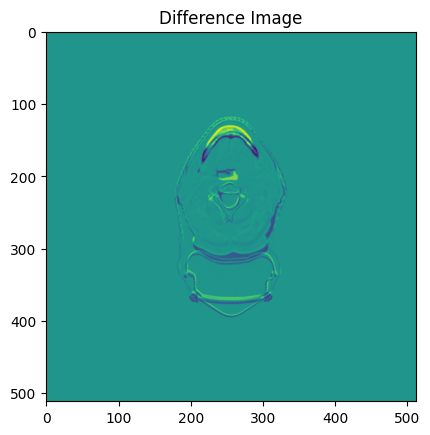

In [34]:
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Load the images using the file paths
fixed_CT_image = sitk.ReadImage(val_data[0]['plan'])  # Load the image from the 'plan' filepath
moving_CT_image = sitk.ReadImage(val_data[0]['repeat'])  # Load the image from the 'repeat' filepath
coordination = val_data[0]['pos']
# Convert SimpleITK images to numpy arrays
fixed_CT_array = sitk.GetArrayFromImage(fixed_CT_image)
moving_CT_array = sitk.GetArrayFromImage(moving_CT_image)

# Calculate the difference between the two CT images
difference = moving_CT_array - fixed_CT_array

print(coordination)
# Visualize a slice of the difference
plt.imshow(difference[100])  # Adjust the index [100] as needed for the correct slice
plt.title('Difference Image')
plt.show()


In [14]:
dim = 256
size = (dim, dim, dim)
pixdim = (2.0, 2.0,2.0)
transforms = Compose([
        LoadImaged(keys=["plan", "repeat"], reader=ITKReader()),
        EnsureChannelFirstd(keys=["plan", "repeat"]),
        # ScaleIntensityd(keys=["plan", "repeat"]),
        Spacingd(keys=["plan", "repeat"], pixdim=pixdim, mode='trilinear'),
        SpatialPadd(keys=["plan", "repeat"], spatial_size=size, mode='constant'),  # Ensure minimum size
        CenterSpatialCropd(keys=["plan", "repeat"], roi_size=size),  # Ensure uniform size
    ])


# train_ds = CacheDataset(data=train_data, transform=transforms, cache_rate=0.5, num_workers=1)
# train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1)

val_ds = CacheDataset(data=val_data, transform=transforms, cache_rate=0.1, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)


Loading dataset: 100%|██████████| 8/8 [00:19<00:00,  2.44s/it]


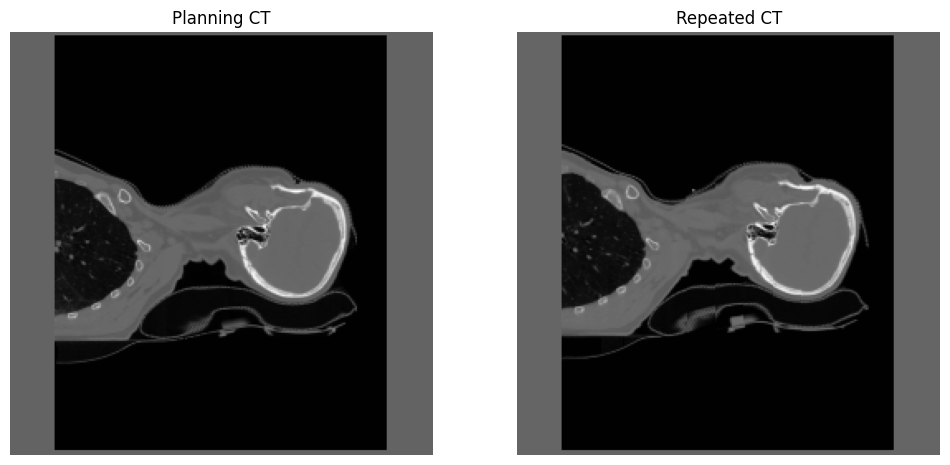

Registration Position: [-0.00985913  0.05096925 -0.4047377 ]


In [17]:
import matplotlib.pyplot as plt
import torch

def plot_sample(data_loader, slice_idx=64):
    """
    Plot a sample of planning and repeated CT images from a DataLoader.
    
    Parameters:
    - data_loader: A DataLoader object.
    - slice_idx: The index of the slice to be visualized from the 3D volume.
    """
    # Fetch a batch of data
    data = next(iter(data_loader))
    planning_images = data['plan']
    repeated_images = data['repeat']
    positions = data['pos']
    
    # Convert to numpy for easier manipulation
    # Assuming the data is a single batch, so index 0 is used
    planning_img_np = planning_images[0, 0].cpu().detach().numpy()  # First 0 for batch index, second 0 for channel
    repeated_img_np = repeated_images[0, 0].cpu().detach().numpy()
    
    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(planning_img_np[slice_idx], cmap='gray')
    ax[0].set_title('Planning CT')
    ax[0].axis('off')

    ax[1].imshow(repeated_img_np[slice_idx], cmap='gray')
    ax[1].set_title('Repeated CT')
    ax[1].axis('off')

    plt.show()

    # Optionally print the position data
    print("Registration Position:", positions[0].numpy())  # Adjust indexing based on your data structure

# Example usage with the training data loader
plot_sample(val_loader, slice_idx=100)


[-0.09859125  0.50969255 -4.047377  ]


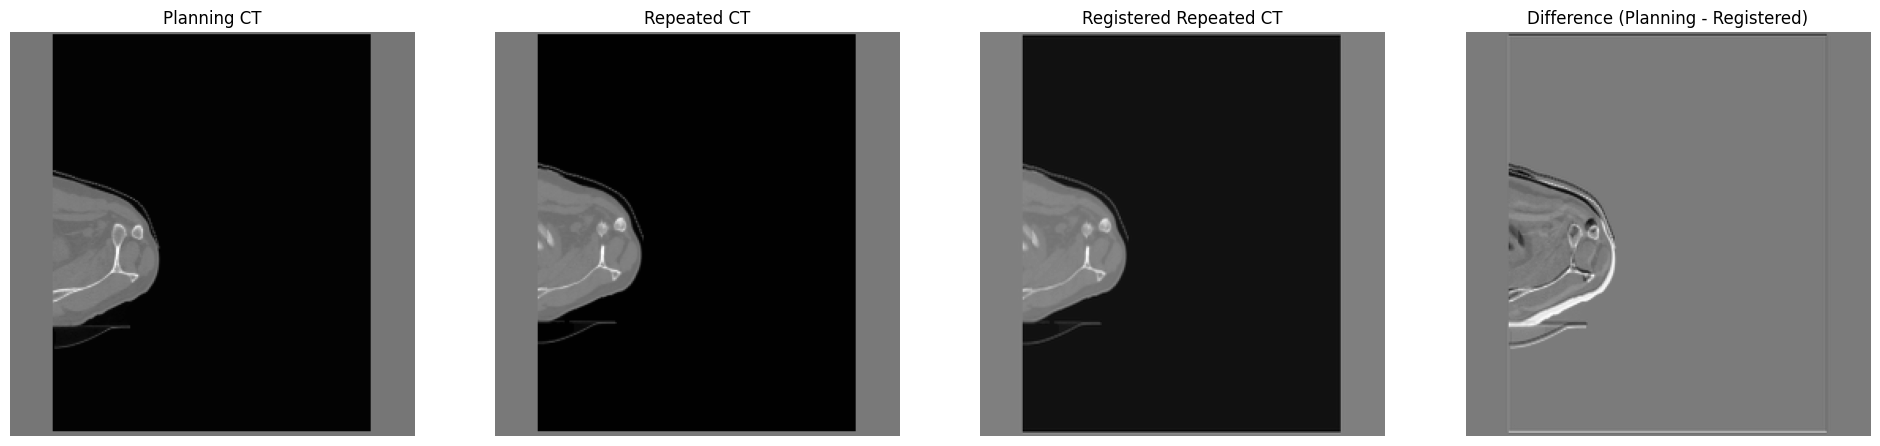

In [28]:
from scipy.ndimage import shift


def apply_registration_and_difference(planning_image, repeated_image, translation):
    """
    Apply translation to the repeated image for registration and compute the difference with the planning image.
    Parameters:
    - planning_image: The planning CT image slice.
    - repeated_image: The repeated CT image slice.
    - translation: The translation coordinates (x, y, z).
    Returns:
    - The translated (registered) repeated image.
    - The difference image between the planning and registered repeated images.
    """
    # Apply translation (registration)
    translation = translation * 10
    registered_repeated_image = shift(repeated_image, shift=(translation[1], translation[0]))  # Shift takes (y, x) for 2D images
    print(translation)
    # Compute difference
    difference_image = planning_image - registered_repeated_image
    
    return registered_repeated_image, difference_image

def plot_registration_and_difference(data_loader, slice_idx=64):
    """
    Plot a sample of planning CT, repeated CT, registered repeated CT, and the difference between planning and registered repeated CT.
    
    Parameters:
    - data_loader: A DataLoader object.
    - slice_idx: The index of the slice to be visualized from the 3D volume.
    """
    # Fetch a batch of data
    data = next(iter(data_loader))
    planning_images = data['plan'][0, 0].cpu().detach().numpy()  # First image in the batch
    repeated_images = data['repeat'][0, 0].cpu().detach().numpy()
    translation_coordinates = data['pos'][0].cpu().detach().numpy()  # Registration translation positions
    
    # Apply registration and compute the difference
    registered_repeated_images, difference_image = apply_registration_and_difference(
        planning_images[slice_idx],
        repeated_images[slice_idx],
        translation_coordinates
    )

    # Plotting
    fig, ax = plt.subplots(1, 4, figsize=(24, 6))
    ax[0].imshow(planning_images[slice_idx], cmap='gray')
    ax[0].set_title('Planning CT')
    ax[0].axis('off')

    ax[1].imshow(repeated_images[slice_idx], cmap='gray')
    ax[1].set_title('Repeated CT')
    ax[1].axis('off')
    
    ax[2].imshow(registered_repeated_images, cmap='gray')
    ax[2].set_title('Registered Repeated CT')
    ax[2].axis('off')

    ax[3].imshow(difference_image, cmap='gray')
    ax[3].set_title('Difference (Planning - Registered)')
    ax[3].axis('off')

    plt.show()

# Use the function with the training data loader to visualize a sample
plot_registration_and_difference(val_loader, slice_idx=64)


In [3]:
# Set parameters
starting_epoch = 0
# decay_epoch = 20
final_epoch = 6
# learning_rate = 0.0001
lambda_reg = 0.000001

# Condition for saving list
# save_list = False
best_mae = np.inf

exception_list = ['']


In [4]:
#### My method


from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, SpatialPadd, CenterSpatialCropd, ScaleIntensityRanged
from monai.data import CacheDataset, DataLoader, Dataset
from monai.transforms import LoadImaged
from monai.data.image_reader import ITKReader
batch_size = 2
dim = 128
size = (dim, dim, dim)
transforms = Compose([
        LoadImaged(keys=["plan", "repeat"], reader=ITKReader()),
        EnsureChannelFirstd(keys=["plan", "repeat"]),
        ScaleIntensityd(keys=["plan", "repeat"]),
        Spacingd(keys=["plan", "repeat"], pixdim=(3.0, 3.0, 3.0), mode='trilinear'),
        SpatialPadd(keys=["plan", "repeat"], spatial_size=size, mode='constant'),  # Ensure minimum size
        CenterSpatialCropd(keys=["plan", "repeat"], roi_size=size),  # Ensure uniform size
    ])


# train_ds = CacheDataset(data=train_data, transform=transforms, cache_rate=1.0, num_workers=2)
# train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

# val_ds = CacheDataset(data=val_data, transform=transforms, cache_rate=1.0, num_workers=2)
# val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

train_ds = SmartCacheDataset(data=train_data, transform=transforms, cache_rate=0.1, replace_rate=0.2, num_init_workers=2, num_replace_workers=2)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

val_ds = SmartCacheDataset(data=val_data, transform=transforms, cache_rate=0.1, replace_rate=0.2, num_init_workers=2, num_replace_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)




Loading dataset: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


In [5]:
# from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, SpatialPadd, CenterSpatialCropd, ScaleIntensityRanged
# from monai.data import CacheDataset, DataLoader, Dataset
# import matplotlib.pyplot as plt

# # Assuming `transforms` is defined and `val_files` contains your validation files
# check_ds = Dataset(data=val_data, transform=transforms)
# check_loader = DataLoader(check_ds, batch_size=1)

# # Manually retrieve the first batch of data
# for check_data in check_loader:
#     break

# plan, repeat = (check_data["plan"][0][0], check_data["repeat"][0][0])
# print(f"image shape: {plan.shape}, target shape: {repeat.shape}")

# # plot the slice [:, :, n]
# n = 100

# plt.figure("check", (12, 6))
# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.imshow(plan[:, :, n], origin="lower")
# plt.subplot(1, 2, 2)
# plt.title("repeat")
# plt.imshow(repeat[:, :, n])
# plt.show()

# lr_finder:

In [6]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

# def find_lr(model, train_loader, optimizer, init_value=1e-8, final_value=10., beta=0.98):
#     num = len(train_loader)-1  # Total number of batches
#     mult = (final_value / init_value) ** (1/num)
#     lr = init_value
#     optimizer.param_groups[0]['lr'] = lr
#     avg_loss = 0.
#     best_loss = 0.
#     batch_num = 0
#     losses = []
#     log_lrs = []
#     for data in train_loader:
#         batch_num += 1
#         # Get the input and target from the batch
#         # This part needs to be adapted to your specific data loader structure
#         # Adjust these lines to match how your data is structured and ensure both inputs are provided
#         inputs_fixed = data["plan"].to(device)
#         inputs_moving = data["repeat"].to(device)
#         targets = data["pos"].to(device)  # Assuming 'pos' is the target
        
#         # Forward pass
#         optimizer.zero_grad()
#         # Make sure to pass both inputs to the model
#         outputs = model(inputs_fixed, inputs_moving)  # Adjusted to pass both inputs
#         # Assuming your model outputs in a format that matches targets, adjust if it outputs a tuple
#         loss = mae_loss(outputs, targets)

#         # Compute the smoothed loss
#         avg_loss = beta * avg_loss + (1-beta) * loss.item()
#         smoothed_loss = avg_loss / (1 - beta**batch_num)

#         # Stop if the loss is exploding
#         if batch_num > 1 and smoothed_loss > 4 * best_loss:
#             return log_lrs, losses

#         # Record the best loss
#         if smoothed_loss < best_loss or batch_num==1:
#             best_loss = smoothed_loss

#         # Store the values
#         losses.append(smoothed_loss)
#         log_lrs.append(np.log10(lr))

#         # Do the backward pass and optimize
#         loss.backward()
#         optimizer.step()

#         # Update the lr for the next step and store
#         lr *= mult
#         optimizer.param_groups[0]['lr'] = lr

#     return log_lrs, losses

# # Call the function
# model.train()
# log_lrs, losses = find_lr(model, train_loader, optimizer)

# # Plotting
# plt.figure(figsize=(6,4))
# plt.plot(log_lrs, losses)
# plt.xlabel("Learning Rate (log scale)")
# plt.ylabel("Loss")
# plt.show()


-----

In [7]:
from dual_network import Dual3DCNN3, Dual3DCNN4, Dual3DCNN5

print('Initializing model...')
model = Dual3DCNN4(width=dim, height=dim, depth=dim)
device = torch.device("cuda:0")
model.to(device)

# Define loss
print('Defining loss...')
mae_loss = torch.nn.L1Loss()
# mae_loss = torch.nn.MSELoss()
from torch.optim.lr_scheduler import ReduceLROnPlateau
learning_rate = 1e-3  # Start with a learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Scheduler (optional, to reduce learning rate when a metric has stopped improving)
# Here, we use ReduceLROnPlateau which reduces learning rate when a metric stops improving
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)


Initializing model...


KeyboardInterrupt: 

In [ ]:
# Training loop

# Initialize best_mae before the training loop
best_mae = float('inf')
train_losses = []

for epoch in range(starting_epoch, final_epoch):
    model.train()  # Set model to training mode
    mae_list = []
    train_loss = []
    # Assuming mae_loss is defined and using the correct device
    for i, batch_data in enumerate(train_loader):
        pCT, rCT = batch_data["plan"].to(device), batch_data["repeat"].to(device)
        reg = batch_data["pos"].to(device)  # No need for clone().detach().requires_grad_(True) for targets
        print(reg)
        # Forward pass
        outx, outy, outz = model(pCT, rCT)
        
        # Split reg into its components (assuming reg has shape [batch_size, 3])
        regx, regy, regz = reg[:, 0], reg[:, 1], reg[:, 2]

        # Calculate MAE for each component
        loss_x = mae_loss(outx, regx.unsqueeze(1))  # Add dimension to match output shape
        loss_y = mae_loss(outy, regy.unsqueeze(1))
        loss_z = mae_loss(outz, regz.unsqueeze(1))

        # Combine the losses (you could also weigh them differently)
        total_loss = (loss_x + loss_y + loss_z)/batch_size
        train_losses.append(total_loss.item())
        
        # Calculate average validation loss
        avg_train_loss = np.mean(train_losses)

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()

        optimizer.step()
        
        # Logging (example for total_loss, adjust as needed)
        # print(f'Epoch: {epoch}/{final_epoch}, Batch: {i+1}/{len(train_loader)}, Loss: {total_loss.item()}')

    # Validation loop
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_data in val_loader:
            pCT_val, rCT_val = batch_data["plan"].to(device), batch_data["repeat"].to(device)
            reg_val = batch_data["pos"].to(device)  # Ground truth coordinates
            
            # Model prediction
            outx_val, outy_val, outz_val = model(pCT_val, rCT_val)
       
            # Split reg_val into its components
            regx_val, regy_val, regz_val = reg_val[:, 0], reg_val[:, 1], reg_val[:, 2]
          
            # Calculate validation loss for each component
            loss_val_x = mae_loss(outx_val, regx_val.unsqueeze(1))
            loss_val_y = mae_loss(outy_val, regy_val.unsqueeze(1))
            loss_val_z = mae_loss(outz_val, regz_val.unsqueeze(1))
            
            # Combine the losses
            total_val_loss = (loss_val_x + loss_val_y + loss_val_z)/batch_size
            print(regx_val)
            val_losses.append(total_val_loss.item())
        
        # Calculate average validation loss
        avg_val_loss = np.mean(val_losses)
        # print(f'Epoch [{epoch+1}/{final_epoch}], Validation Loss: {avg_val_loss:.4f}')


        # Adjust learning rate
        scheduler.step(avg_val_loss)
        
        


        # Saving model and logging
        save_dir = '/home/shahpouriz/Data/DBP_Project/LOG'
        filename = f'loss_Model_3f_1p'
        loss_file = os.path.join(save_dir, f'{filename}.txt')

        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        
        if avg_val_loss <= best_mae and epoch > 0:
            best_mae = avg_val_loss
            model_filename = f'{filename}_{epoch+1}.pt'  # Store the model filename
            torch.save(model.state_dict(), os.path.join(save_dir, model_filename))
            print(f'Model saved to {os.path.join(save_dir, model_filename)}')
        
        # Append current epoch's average loss and validation loss to the log file
        with open(loss_file, 'a') as f:
            f.write(f'Epoch: {epoch+1}/{final_epoch}, Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}\n')
            # f.write(f'Epoch: {epoch+1}/{final_epoch}, Loss: {avg_train_loss}, Val: {mean_val_loss}\n')


tensor([[-0.1106, -0.0269,  0.0127]], device='cuda:0')


ValueError: not enough values to unpack (expected 3, got 1)

In [ ]:

# # Initialize best_mae before the training loop
# best_mae = float('inf')
# train_losses = []

# # Training loop
# for epoch in range(starting_epoch, final_epoch):
#     model.train()  # Set model to training mode
#     mae_list = []
#     train_loss = []
#     # Assuming mae_loss is defined and using the correct device
#     for i, batch_data in enumerate(train_loader):
#         pCT, rCT = batch_data["plan"].to(device), batch_data["repeat"].to(device)
#         reg = batch_data["pos"].to(device)  # No need for clone().detach().requires_grad_(True) for targets
        
#         # Forward pass
#         outx, outy, outz = model(pCT, rCT)
        
#         # Split reg into its components (assuming reg has shape [batch_size, 3])
#         regx, regy, regz = reg[:, 0], reg[:, 1], reg[:, 2]

#         # Calculate MAE for each component
#         loss_x = mae_loss(outx, regx.unsqueeze(1))  # Add dimension to match output shape
#         loss_y = mae_loss(outy, regy.unsqueeze(1))
#         loss_z = mae_loss(outz, regz.unsqueeze(1))

#         # Combine the losses (you could also weigh them differently)
#         total_loss = (loss_x + loss_y + loss_z)/batch_size
#         train_losses.append(total_loss.item())
        
#         # Calculate average validation loss
#         avg_train_loss = np.mean(train_losses)
#         # Backpropagation
#         optimizer.zero_grad()
#         total_loss.backward()
#         # loss_y.backward()
#         # loss_z.backward()

#         optimizer.step()
        
#         # Logging (example for total_loss, adjust as needed)
#         print(f'Epoch: {epoch}/{final_epoch}, Batch: {i+1}/{len(train_loader)}, Loss: {total_loss.item()}')

#     # Validation loop
#     model.eval()
#     val_losses = []
#     with torch.no_grad():
#         for batch_data in val_loader:
#             pCT_val, rCT_val = batch_data["plan"].to(device), batch_data["repeat"].to(device)
#             reg_val = batch_data["pos"].to(device)  # Ground truth coordinates
            
#             # Model prediction
#             outx_val, outy_val, outz_val = model(pCT_val, rCT_val)
#             print(outx_val, outy_val, outz_val)
#             # Split reg_val into its components
#             regx_val, regy_val, regz_val = reg_val[:, 0], reg_val[:, 1], reg_val[:, 2]
#             print(regx_val, regy_val, regz_val)
#             # Calculate validation loss for each component
#             loss_val_x = mae_loss(outx_val, regx_val.unsqueeze(1))
#             loss_val_y = mae_loss(outy_val, regy_val.unsqueeze(1))
#             loss_val_z = mae_loss(outz_val, regz_val.unsqueeze(1))
            
#             # Combine the losses
#             total_val_loss = (loss_val_x + loss_val_y + loss_val_z)/batch_size
            
#             val_losses.append(total_val_loss.item())
        
#         # Calculate average validation loss
#         avg_val_loss = np.mean(val_losses)
#         print(f'Epoch [{epoch+1}/{final_epoch}], Validation Loss: {avg_val_loss:.4f}')


#         # Adjust learning rate
#         lr_scheduler.step()
        
        


#         # Saving model and logging
#         save_dir = '/home/shahpouriz/Data/DBP_Project/LOG'
#         filename = f'loss_Model_3f'
#         loss_file = os.path.join(save_dir, f'{filename}.txt')

#         if not os.path.isdir(save_dir):
#             os.makedirs(save_dir)
        
#         if avg_val_loss <= best_mae and epoch > 0:
#             best_mae = avg_val_loss
#             model_filename = f'{filename}_{epoch+1}.pt'  # Store the model filename
#             torch.save(model.state_dict(), os.path.join(save_dir, model_filename))
#             print(f'Model saved to {os.path.join(save_dir, model_filename)}')
        
#         # Append current epoch's average loss and validation loss to the log file
#         with open(loss_file, 'a') as f:
#             f.write(f'Epoch: {epoch+1}/{final_epoch}, Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}\n')
#             # f.write(f'Epoch: {epoch+1}/{final_epoch}, Loss: {avg_train_loss}, Val: {mean_val_loss}\n')


In [ ]:
# Training loop
for epoch in range(starting_epoch, final_epoch):
    
    # model.train()  # Set model to training mode
    mae_list = []
    train_loss = []
    for i, batch_data in enumerate(train_loader):  # Use enumerate to get the batch index
        pCT, rCT = batch_data["plan"].to(device), batch_data["repeat"].to(device)
        reg = batch_data["pos"].clone().detach().requires_grad_(True).to(device)  # If gradients are required for 'reg'
        print("*****************************************")
        print(reg)

        # Forward pass
        output = model(pCT, rCT)
        print(output)
        loss_output = mae_loss(output, reg)
        print(loss_output)


        # L1 Regularization
        l1_reg = torch.tensor(0., requires_grad=True).to(device)
        for name, param in model.named_parameters():
            l1_reg = l1_reg + torch.norm(param, 1)
        loss_output += lambda_reg * l1_reg
        print(loss_output)
        
        # Backpropagation
        optimizer.zero_grad()
        loss_output.backward()  
        optimizer.step()
        
        # Logging
        mae_list.append(loss_output.item())
        mean_mae = np.mean(mae_list)
        # Corrected to print the current batch number
        print(f'Epoch: {epoch}/{final_epoch}, Batch: {i+1}/{len(train_loader)}, Loss_avg: {mean_mae}')

    # Validation loop
    # model.eval()
    val_loss = []
    with torch.no_grad():
        for batch_data in val_loader:
            pCT_val, rCT_val = batch_data["plan"].to(device), batch_data["repeat"].to(device)
            reg_val = batch_data["pos"].clone().detach().requires_grad_(True).to(device)  # If gradients are required for 'reg'

            output_val = model(pCT_val, rCT_val)
            loss_output_val = mae_loss(output_val, reg_val)

            val_loss.append(loss_output_val.item())

            mean_val_loss = np.mean(val_loss)
            print(f'Epoch [{epoch+1}/{final_epoch}], Validation Loss: {mean_val_loss:.4f}')

    # Adjust learning rate
    lr_scheduler.step()
    
    save_dir = '/home/shahpouriz/Data/DBP_Project/LOG'
    filename = f'loss_simple_Model_{dim}'
    loss_file = fr'/home/shahpouriz/Data/DBP_Project/LOG/{filename}.txt'

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    
    current_valid_mae = val_loss[-1]    
    print(f'Epoch: {epoch+1}, Current Valid MAE: {current_valid_mae}, Best MAE: {best_mae}')
    if current_valid_mae <= best_mae and epoch > 0:
        best_mae = current_valid_mae
        model_filename = f'{filename}_{epoch+1}.pt'
        model_path = f'{save_dir}/{model_filename}'
        torch.save(model.state_dict(), model_path)
        print(f'Model saved: {model_path}')
    else:
        pass


*****************************************
tensor([[-0.8186, -0.2103, -1.5246],
        [-1.0367, -0.3661,  0.6014]], device='cuda:0',
       grad_fn=<ToCopyBackward0>)
(metatensor([[-0.2432],
        [-0.2429]], device='cuda:0', grad_fn=<AliasBackward0>), metatensor([[-0.0306],
        [-0.0305]], device='cuda:0', grad_fn=<AliasBackward0>), metatensor([[0.0992],
        [0.0991]], device='cuda:0', grad_fn=<AliasBackward0>))


AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
# count = 0
# for pct_tensor, rct_tensor, pos in train_dataset:
#     print("pCT Tensor:", pct_tensor.shape)
#     print("rCT Tensor:", rct_tensor.shape)
#     print("Position:", pos)
#     count += 1
#     if count == 1:
#         break



In [ ]:

# # Build model
# print('Initializing model...')
# model = Dual(width=512, height=512, depth=512)
# device = torch.device(f"cuda:{device_num}" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Define loss
# print('Defining loss...')
# mae_loss = torch.nn.L1Loss()
# mse_loss = torch.nn.MSELoss()

# # Define optimizer
# print('Defining optimizer...')
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# # Define scheduler
# print('Defining scheduler...')
# lr_lambda = DecayLR(epochs=final_epoch, offset=0, decay_epochs=decay_epoch).step
# lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


In [ ]:
# # Initialize model
# model = Dual(width=512, height=512, depth=512)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Define loss
# mae_loss = torch.nn.L1Loss()
# mse_loss = torch.nn.MSELoss()

# # Define optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# # Define scheduler
# lr_lambda = DecayLR(epochs=final_epoch, offset=0, decay_epochs=decay_epoch).step
# lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# # Training loop
# for epoch in range(starting_epoch, final_epoch):
#     mae_list = []
#     model.train()  # Set model to training mode
#     for i, (pCT, rCT, reg) in enumerate(train_loader):
#         pCT = pCT.to(device)
#         rCT = rCT.to(device)
#         reg = reg = reg[0].unsqueeze(1).to(device)  # Access the element of the list and move it to the device


        
#         # Forward pass
#         output = model(pCT, rCT)
#         output = output.to(torch.float32)
#         reg = reg.to(torch.float32)
#         # Calculate loss
#         loss_output = mse_loss(output, reg)

            
#         # L1 Regularization
#         l1_reg = torch.tensor(0., requires_grad=True).to(device)
#         for name, param in model.named_parameters():
#             l1_reg = l1_reg + torch.norm(param, 1)
#         loss_output += lambda_reg * l1_reg
        
#         # Backpropagation
#         optimizer.zero_grad()
#         loss_output.backward()
#         optimizer.step()
        
#         # Logging
#         mae_list.append(loss_output.item())
#         mean_mae = np.mean(mae_list)
#         print(f'Epoch: {epoch}/{final_epoch}, Batch: {i}/{len(train_loader)}, Loss_avg: {mean_mae}')
    
#     # Validation loop
#     model.eval()  # Set model to evaluation mode
#     val_loss = []
#     with torch.no_grad():
#         for j, (pCT_val, rCT_val, reg_val) in enumerate(val_loader):
#             pCT_val = pCT_val.to(device)
#             rCT_val = rCT_val.to(device)
#             reg_val = reg_val.to(device)
            
#             output_val = model(pCT_val, rCT_val)
#             loss_output_val = mae_loss(output_val, reg_val)
            
#             val_loss.append(loss_output_val.item())
#             mean_val_loss = np.mean(val_loss)
#             print(f'Epoch: {epoch}/{final_epoch}, Batch: {j}/{len(val_loader)}, Loss_avg: {mean_val_loss}')
    
#     # Adjust learning rate
#     lr_scheduler.step(mean_val_loss)
    
#     save_dir = '/home/shahpouriz/Data/DBP_Project/LOG'
#     fname_comment = 'test'
#     loss_file = fr'/home/shahpouriz/Data/DBP_Project/LOG/loss_dose_json_simpleModel_{fname_comment}.txt'

#     # Save model
#     if not os.path.isdir(save_dir):
#         os.makedirs(save_dir)
    
#     current_valid_mae = val_loss[-1]    
#     if current_valid_mae <= best_mae and epoch > 0:
#         best_mae = current_valid_mae
#         torch.save(model.state_dict(),f'{save_dir}/model_weights_dose_{epoch+1}_{fname_comment}.pt')
#     with open(loss_file, 'a') as f: #a-append
#         f.write(f'Epoch: {epoch+1}/{final_epoch}, Loss: {mean_mae}, Val: {mean_val_loss}\n')
